### 1.Load and Organize Data

In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
# !unzip /content/drive/MyDrive/Datasets/PlantData.zip

In [30]:
# !mkdir /content/PlantVillage/POTATO
# !cp -a /content/PlantVillage/Potato___Early_blight/. /content/PlantVillage/POTATO/Potato___Early_blight
# !cp -a /content/PlantVillage/Potato___Late_blight/. /content/PlantVillage/POTATO/Potato___Late_blight
# !cp -a /content/PlantVillage/Potato___healthy/. /content/PlantVillage/POTATO/Potato___healthy

In [31]:
# DATASET_ROOT = "/content/PlantVillage/POTATO"
DATASET_ROOT = "PlantVillage/"

In [32]:
#!pip install protobuf==3.20.*

In [33]:
import tensorflow as tf 
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [34]:
# import tensorflow.compat.v1 as tf 
# tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 
# print(tf.add([1.0, 2.0], [3.0, 4.0])) 

### 2.Processing the Images

In [35]:
import tensorflow as tf
from tensorflow.keras import models, layers
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from numpy import expand_dims
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [36]:
def plt_show(image,title):
  plt.figure(figsize=(10,5))
  plt.title(title)
  plt.imshow((image * 255).astype(np.uint8))

In [37]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 5

In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(DATASET_ROOT,shuffle=True,image_size = (IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [39]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


#### Visualize Batch

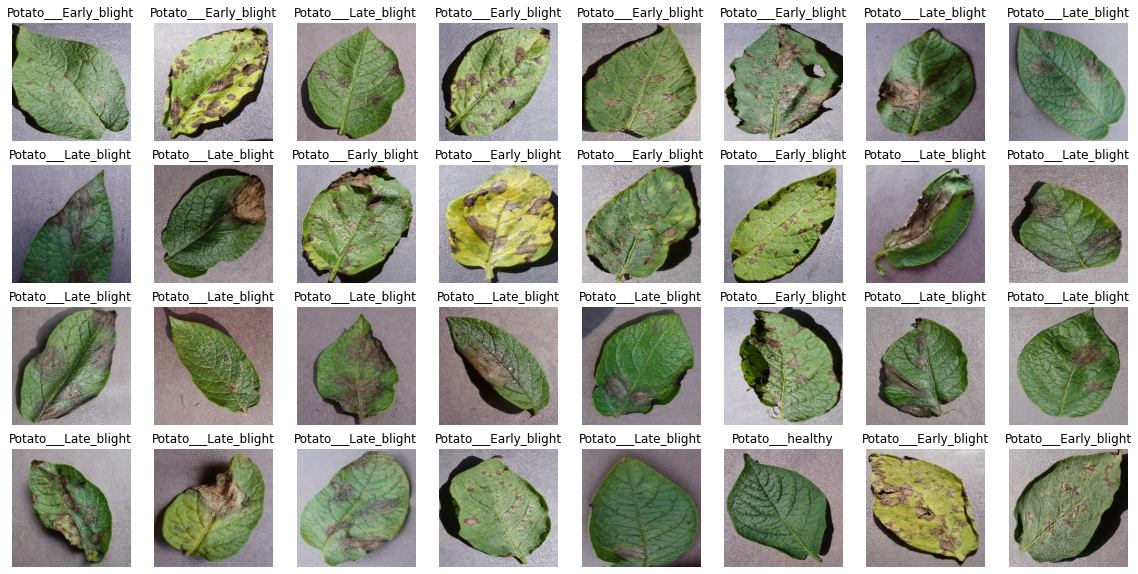

In [40]:
plt.figure(figsize=(20, 10))
for images,labels in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [41]:
train_size = int(0.80 * len(dataset))
test_size = int(0.10 * len(dataset))
val_size = int(0.10 * len(dataset))

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.take(val_size)
test_dataset = test_dataset.skip(test_size)

print("Size of Train = ",len(train_dataset))
print("Size of Test = ",len(test_dataset))
print("Size of Val = ",len(val_dataset))

Size of Train =  54
Size of Test =  8
Size of Val =  6


#### Caching and Pre-fetching

In [42]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#### Resizing and Scaling

In [43]:
resize_rescale = tf.keras.Sequential([
                                      layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                                      layers.experimental.preprocessing.Rescaling(1.0/255)
])

#### Augumentation

In [44]:
augumentation  = tf.keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                      layers.experimental.preprocessing.RandomRotation(0.2)
])

### 3.Build Model

#### Model Building

In [45]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
model = models.Sequential([
                           resize_rescale,
                           augumentation,
                           layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, (3,3), activation='relu'),
                           layers.Flatten(),
                           layers.Dense(64,activation='relu'),
                           layers.Dense(3,activation='softmax')
])
model.build(input_shape)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (32, 1000000)             0         
_________________________________________________________________
dense_2 (Dense)              (32, 64)                 

In [46]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [47]:
history = model.fit(train_dataset,epochs = EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_dataset)

Epoch 1/5
54/54 [==============================] - 37s 664ms/step - loss: 2.9010 - accuracy: 0.7002 - val_loss: 0.6214 - val_accuracy: 0.7552
Epoch 2/5
54/54 [==============================] - 36s 662ms/step - loss: 0.4404 - accuracy: 0.8385 - val_loss: 0.4851 - val_accuracy: 0.7448
Epoch 3/5
54/54 [==============================] - 37s 692ms/step - loss: 0.3690 - accuracy: 0.8524 - val_loss: 0.3639 - val_accuracy: 0.8438
Epoch 4/5
54/54 [==============================] - 37s 691ms/step - loss: 0.3233 - accuracy: 0.8773 - val_loss: 0.3441 - val_accuracy: 0.8281
Epoch 5/5
54/54 [==============================] - 35s 656ms/step - loss: 0.3086 - accuracy: 0.8976 - val_loss: 0.1094 - val_accuracy: 0.9688


In [48]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 2s 144ms/step - loss: 0.1087 - accuracy: 0.9784


#### Decompose the Network Architechture

In [49]:
conv_layer_index = []
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    conv_layer_index.append(i)
    print(i , layer.name , layer.output.shape)
print("Con Layers Index  =",conv_layer_index)

2 conv2d_2 (None, 254, 254, 32)
4 conv2d_3 (None, 125, 125, 64)
Con Layers Index  = [2, 4]


In [50]:
outputs = [model.layers[i].output for i in conv_layer_index]
model_vis = models.Model(inputs=model.inputs,outputs=outputs)
model_vis.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3_input (InputLay [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 64)      18496     
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_______________________________________________________

In [51]:
image = load_img("PlantVillage/Potato___Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG" , target_size=(IMAGE_SIZE,IMAGE_SIZE))
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)
#calculating features_map
features = model_vis.predict(image)

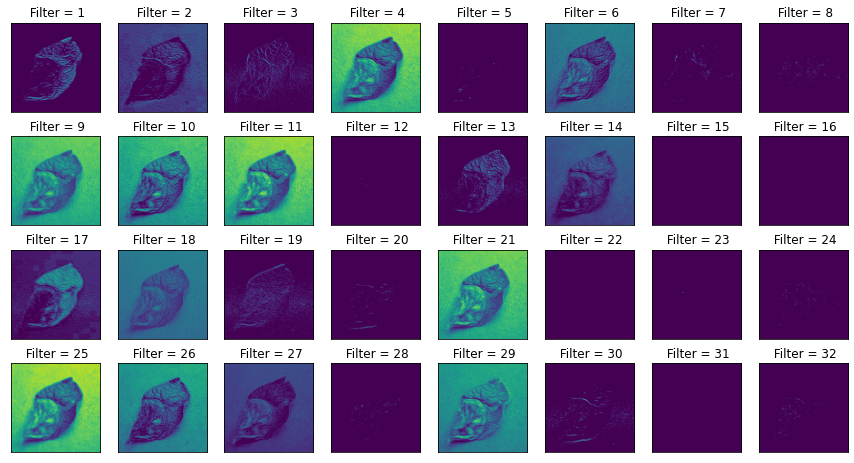

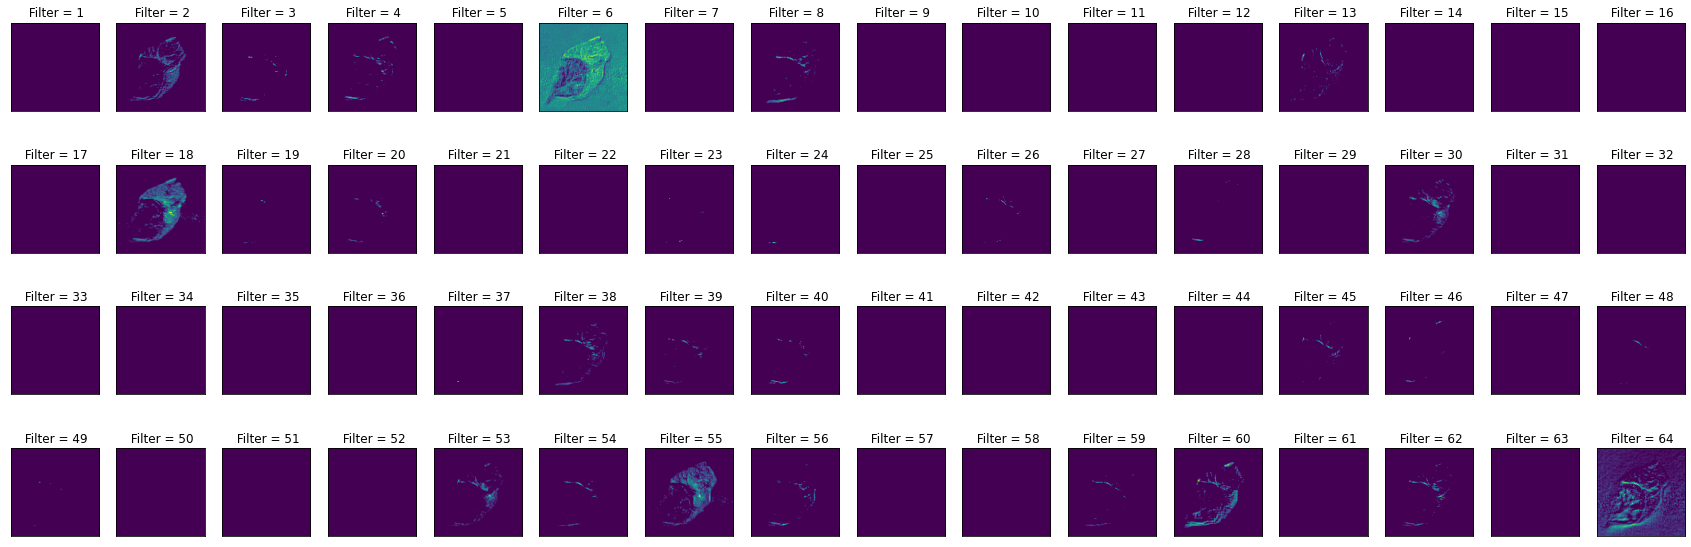

In [52]:
for feature in features:
  kernel_size = feature.shape[3] 
  if kernel_size == 32:
    rows,cols = 4,8
    figsize= (15,8)
  elif kernel_size == 64:
    rows,cols = 4,16
    figsize= (30,10)
  fig = plt.figure(figsize=figsize)

  for i in range(1,rows*cols+1):
    fig = plt.subplot(rows,cols,i)
    fig.set_xticks([])
    fig.set_yticks([])
    plt.title(" Filter = "+str(i))
    plt.imshow(feature[0,:,:,i-1])
    
  plt.show()


In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Train and Val Loss')

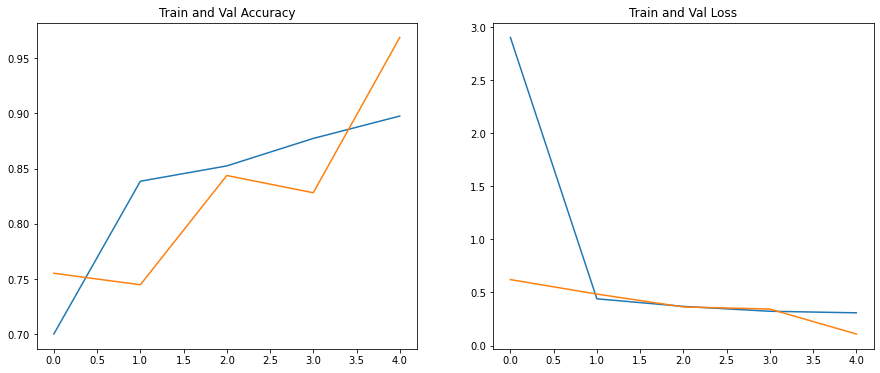

In [54]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Train Accuracy')
plt.plot(range(EPOCHS), val_acc,label='Val Accuracy')
plt.title('Train and Val Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Train Loss')
plt.plot(range(EPOCHS), val_loss,label='Val Loss')
plt.title('Train and Val Loss')


#### Test Inference

Actual =  Potato___Early_blight
Predicted =  Potato___Early_blight


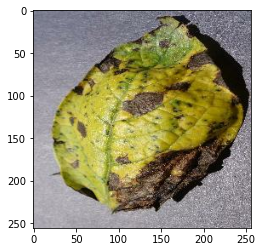

In [55]:
for images_batch, labels_batch in test_dataset.take(1):
  image = images_batch[0].numpy().astype('uint8')
  label = labels_batch[0]
  plt.imshow(image)
  print("Actual = ",class_names[label])
  batch_prediction = model.predict(images_batch)
  print("Predicted = ",class_names[np.argmax(batch_prediction[0])])

In [64]:
def predict(model, img):
  img_array = img_to_array(images[i].numpy())
  img_array = expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class, confidence

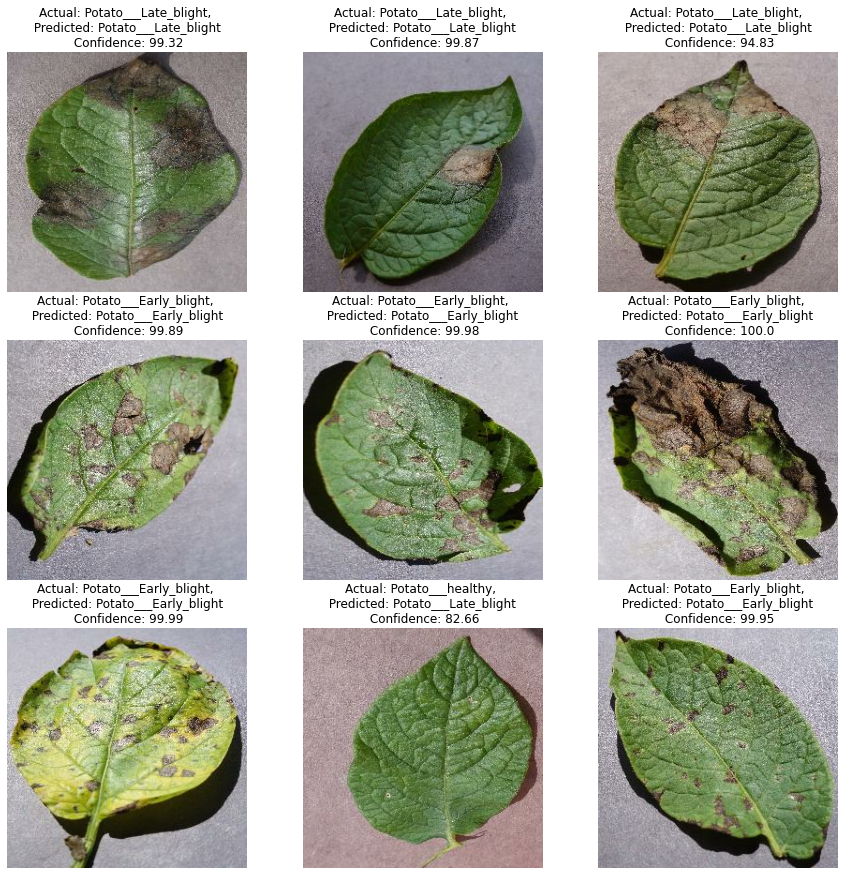

In [65]:
plt.figure(figsize=(15,15))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}')
    plt.axis("off")

#### Save the Model

In [58]:
model_name = 'model_val_acc_'+str(history.history['val_accuracy'][-1])
model.save(f"./models/{model_name}")

INFO:tensorflow:Assets written to: ./models/model_val_acc_0.96875\assets


In [59]:
model_name

'model_val_acc_0.96875'

### 4.Fast API-Expose the Model

In [67]:
# pip install fastapi nest-asyncio pyngrok uvicorn python-multipart

#### Build App

In [82]:
from fastapi import FastAPI,File,UploadFile
from fastapi.middleware.cors import CORSMiddleware
from io import BytesIO
from PIL import Image
import uvicorn

# https://stackoverflow.com/questions/55409641/asyncio-run-cannot-be-called-from-a-running-event-loop 
import nest_asyncio
nest_asyncio.apply()

model = models.load_model("models/model_val_acc_0.96875/")
CLASS_NAMES = ["Early Blight" ,"Late Blight","Healthy"]

app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)
@app.get('/ping')
async def ping():
  return "Hello"

def read_file_as_image(data) -> np.ndarray:
    image = np.array(Image.open(BytesIO(data)))
    return image

@app.post("/predict")
async def predict(file:UploadFile = File(...)):
  image = read_file_as_image(await file.read())
  image_batch = np.expand_dims(image,0)
  predictions = model.predict(image_batch)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = np.max(predictions[0])
  return { 'class':predicted_class ,'confidence':round(confidence *100,2)}

#### Run App

In [83]:
if __name__ == "__main__":
    uvicorn.run(app,host='localhost',port=8000)

INFO:     Started server process [28636]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://localhost:8000 (Press CTRL+C to quit)


INFO:     ::1:60766 - "POST /predict HTTP/1.1" 200 OK
INFO:     ::1:49680 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [28636]
